In [1]:
import sys
print(sys.version)

3.6.9 |Anaconda custom (64-bit)| (default, Jul 30 2019, 13:42:17) 
[GCC 4.2.1 Compatible Clang 4.0.1 (tags/RELEASE_401/final)]


In [2]:
"""
Created on Mar 3 2020
@author: Neven Caplar
@contact: ncaplar@princeton.edu

These comments are theoretically the only ones you need to read to run the notebook

1. Specify the directory in which you want to run the analysis below (PSF_DIRECTORY)
2. Name and place the data in DATA_FOLDER. The data is avaliable at https://github.com/nevencaplar/PFS_Work_In_Progress/tree/master/CutsForTigerMay2
3. TESTING_FOLDER will be filled during the run with images from the analysis analysis

4. (OPTIONAL)Next cell contains some extensions that I use that make life much easier when using jupyter notebook 
    Without them this notebook becomes reallllly huge and hard to deal with
    These can be downloaded from https://github.com/ipython-contrib/jupyter_contrib_nbextensions

"""
############################################################
# name your directory where you want to have files!
PSF_DIRECTORY='/Users/nevencaplar/Documents/PFS/'
# place cutouts in this folder - name as you wish
DATA_FOLDER=PSF_DIRECTORY+'TigerAnalysis/CutsForTigerMay2/'
############################################################
    

TESTING_FOLDER=PSF_DIRECTORY+'Testing/'
TESTING_PUPIL_IMAGES_FOLDER=TESTING_FOLDER+'Pupil_Images/'
TESTING_WAVEFRONT_IMAGES_FOLDER=TESTING_FOLDER+'Wavefront_Images/'
TESTING_FINAL_IMAGES_FOLDER=TESTING_FOLDER+'Final_Images/'
import os

for i in [PSF_DIRECTORY,DATA_FOLDER,TESTING_PUPIL_IMAGES_FOLDER,TESTING_WAVEFRONT_IMAGES_FOLDER,TESTING_FINAL_IMAGES_FOLDER]:
    if not os.path.exists(i):
        os.makedirs(i)

In [3]:
%%javascript
try {
  require(['base/js/utils'], function (utils) {
    utils.load_extension('code_prettify/code_prettify');
    utils.load_extension('collapsible_headings/main'); 
    utils.load_extension('codefolding/edit'); 
    utils.load_extension('codefolding/main'); 
    utils.load_extension('execute_time/ExecuteTime');   
    utils.load_extension('toc2/main'); 
  });
}
catch (err) {
  console.log('toc2 load error:', err);
}

<IPython.core.display.Javascript object>

In [4]:
# make notebook nice and wide to fill the entire screen
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [5]:
%load_ext autoreload
%autoreload 2

#import Zernike_Module
#from Zernike_Module import LNP_PFS,LN_PFS_single,create_parInit,downsample_manual_function,Zernike_Analysis,PFSPupilFactory,custom_fftconvolve,stepK,maxK,sky_scale,sky_size,create_x,remove_pupil_parameters_from_all_parameters

import Zernike_Module
import Zernike_Analysis_Module
from Zernike_Module import *
from Residual_1D_module import * 
from Zernike_Analysis_Module import *




In [6]:
import galsim
import numpy as np
np.set_printoptions(suppress=True)
np.seterr(divide='ignore', invalid='ignore')
import pandas as pd
import io
import math
import pickle
import glob

#tqdm is not necesarry, it is the monitor evaluation of the 'for' loops
from tqdm import tqdm

# lsst stack
#import lsst.afw
#from lsst.afw.cameraGeom import PupilFactory
#from lsst.afw.geom import Angle, degrees
#from lsst.afw import geom
#from lsst.afw.geom import Point2D

# astropy
import astropy
import astropy.convolution
from astropy.convolution import Gaussian2DKernel

# scipy and skimage
#from scipy.ndimage import gaussian_filter
import scipy.misc
import skimage.transform

#lmfit
import lmfit

#matplotlib
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
matplotlib.rcParams.update({'font.size': 18})
%config InlineBackend.rc = {}
%matplotlib inline
%config IPython.matplotlib.backend = "retina"

from shutil import copy
from scipy.optimize import curve_fit

def lin_fit_1D(x, a, b):
    return a * x + b

def lin_fit_1DConstant(x, b):
    return  np.full(len(x),b)

def lin_fit_2D(x,y, a, b,c):
    return a * x + b*y+c



print(np.__version__)
print(skimage.__version__)
print(scipy.__version__)

1.17.4
0.15.0
1.3.1


## unit test 

In [7]:
columns=['z4','z5','z6','z7','z8','z9','z10','z11',
          'hscFrac','strutFrac','dxFocal','dyFocal','slitFrac','slitFrac_dy',
          'radiometricEffect','radiometricExponent','x_ilum','y_ilum',
          'x_fiber','y_fiber','effective_radius_illumination',
          'frd_sigma','frd_lorentz_factor','det_vert','slitHolder_frac_dx',
          'grating_lines','scattering_slope','scattering_amplitude',
          'pixel_effect','fiber_r','flux']  

sci_image_unit=np.ones((50,50))
var_image_unit=np.ones((50,50))
#array([     0.85110826,      0.73047372,     -0.31672873,     -0.00539844, -0.32264156,     -0.04922217,     -0.49565709,      0.18057418,
#            0.79993531,      0.10032969,      0.08769052,      0.25372595,          0.06064503,      0.21049747,   
#           0.45840763,      2.05047984,  0.30893478,     -0.13166649, 
#           -0.06752367,     -0.13093007,            0.89197452, 
#           0.10757197,   0.60969064,      1.06409559,   0.14192374, 
#           109336.61223169,   2.41053199,      0.00379578,
#            0.4673993 ,      1.88555321,      0.99733826])
allparameters_proposal=np.array([24,0.09,0.02,-0.1,0.0,0.1,0.02,0.2,
                                 0.7,0.1,0.3,0.0,0.07,0.0,
                                 0.17,0.67,1,1,
                                 0.0,-0.0,0.80,
                                 0.01,0.51,1.06,0.28,
                                 50000,2.5,0.027,
                                 0.37,1.85,1.0])
print('version of the code is: '+str(Zernike_Module.__version__))
model = LN_PFS_single(sci_image_unit,var_image_unit,dithering=1,save=1)   

res=model(allparameters_proposal,return_Image=True)
print(res[0])

version of the code is: 0.27
x:[0, 0, 0, 0]
primary_offset_axis_0_mod_from_floor,primary_offset_axis_1_mod_from_floor(0, 0)
x:[-30.39029875 -21.77945254]
primary_offset_axis_0_mod_from_floor,primary_offset_axis_1_mod_from_floor(0.2205474588836971, 0.6097012499034093)
x:[-19.39029875   0.22054746]
primary_offset_axis_0_mod_from_floor,primary_offset_axis_1_mod_from_floor(0.2205474588836971, 0.6097012499034093)
x:[-13.89029875 -10.77945254]
primary_offset_axis_0_mod_from_floor,primary_offset_axis_1_mod_from_floor(0.2205474588836971, 0.10970124990340935)
x:[-24.89029875  11.22054746]
primary_offset_axis_0_mod_from_floor,primary_offset_axis_1_mod_from_floor(0.2205474588836971, 0.10970124990340935)
x:[-22.14029875  -5.27945254]
primary_offset_axis_0_mod_from_floor,primary_offset_axis_1_mod_from_floor(0.7205474588836971, 0.8597012499034093)
x:[-11.14029875  16.72054746]
primary_offset_axis_0_mod_from_floor,primary_offset_axis_1_mod_from_floor(0.7205474588836971, 0.8597012499034093)
x:[-16.640

In [11]:
pupililluminated=np.load(TESTING_PUPIL_IMAGES_FOLDER+'pupil.illuminated.npy')
ilum=np.load(TESTING_PUPIL_IMAGES_FOLDER+'ilum.npy')
radiometricEffectArray=np.load(TESTING_PUPIL_IMAGES_FOLDER+'radiometricEffectArray.npy')
optPsf=np.load(TESTING_FINAL_IMAGES_FOLDER+'optPsf.npy')
ilum_radiometric=np.load(TESTING_PUPIL_IMAGES_FOLDER+'ilum_radiometric.npy')
wf_full=np.load(TESTING_WAVEFRONT_IMAGES_FOLDER+'wf_full.npy') 

optPsf_cut_fiber_convolved=np.load(TESTING_FINAL_IMAGES_FOLDER+'optPsf_cut_fiber_convolved.npy')
optPsf_cut_pixel_response_convolved=np.load(TESTING_FINAL_IMAGES_FOLDER+'optPsf_cut_pixel_response_convolved.npy')
optPsf_cut_grating_convolved=np.load(TESTING_FINAL_IMAGES_FOLDER+'optPsf_cut_grating_convolved.npy')
optPsf_cut_fiber_convolved_downsampled=np.load(TESTING_FINAL_IMAGES_FOLDER+'optPsf_cut_fiber_convolved_downsampled.npy')



res_iapetus=res[1]

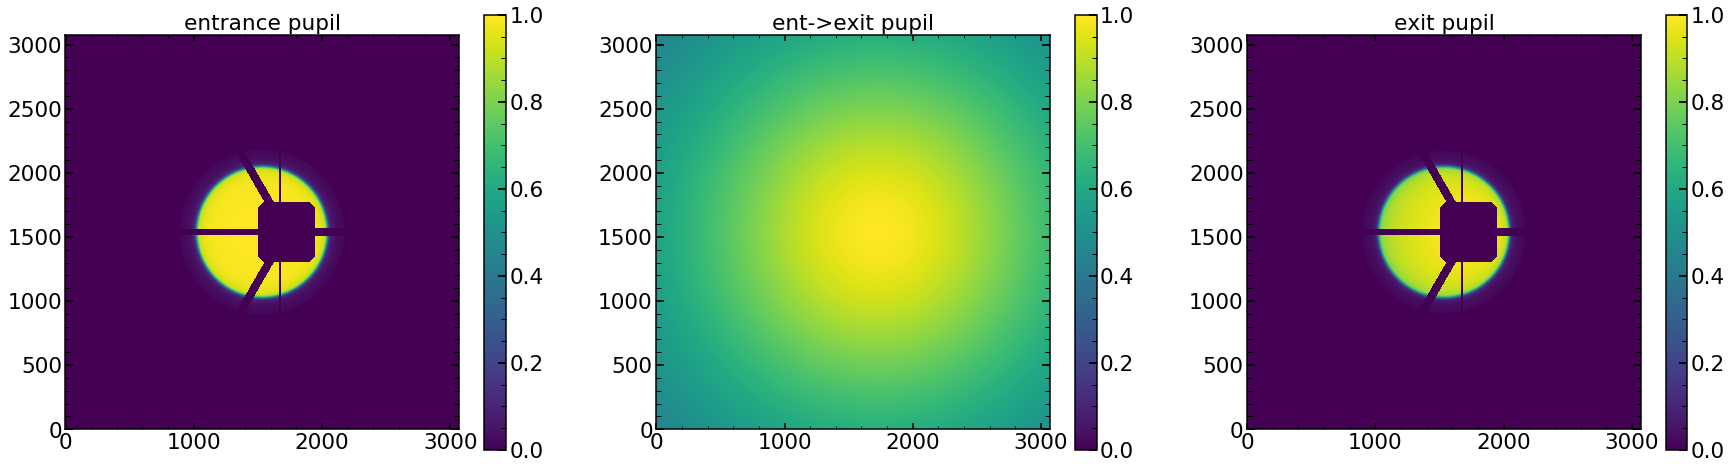

In [12]:
plt.figure(figsize=(30,8))
plt.subplot(131)
plt.imshow(ilum,origin='lower',vmax=1,vmin=0)
plt.title('entrance pupil')
plt.colorbar()
plt.subplot(132)
plt.title('ent->exit pupil')
plt.imshow(radiometricEffectArray,origin='lower',vmax=1,vmin=0)

plt.colorbar()
plt.subplot(133)
plt.title('exit pupil')
plt.imshow(ilum_radiometric,origin='lower',vmax=1,vmin=0)
plt.colorbar()

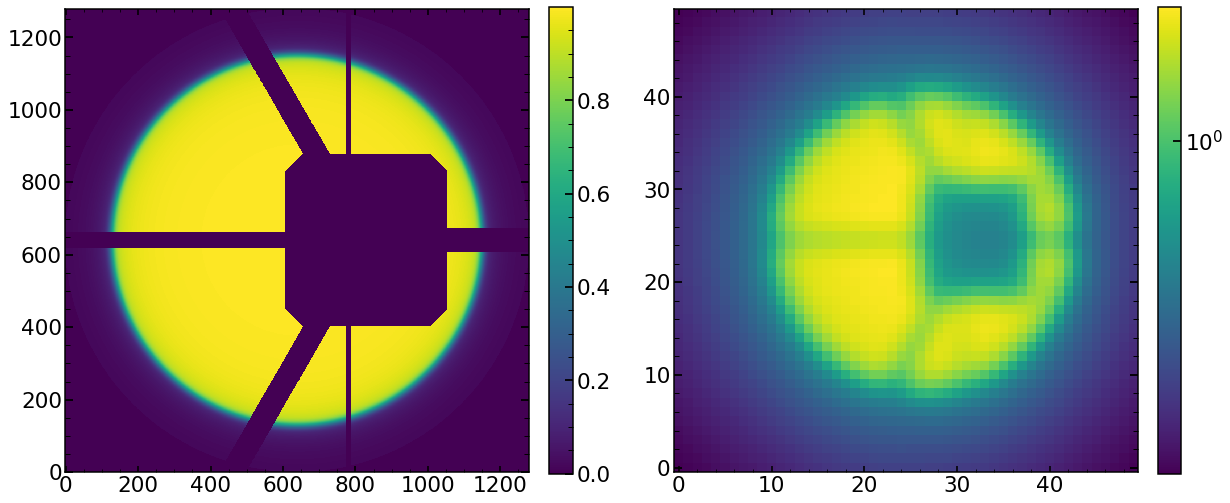

In [13]:
plt.figure(figsize=(20,20))
plt.subplot(121)
plt.imshow(pupililluminated,origin='lower')
cbar=plt.colorbar(fraction=0.046, pad=0.04)

plt.subplot(122)
plt.imshow(res_iapetus,norm=LogNorm(),origin='lower')
cbar=plt.colorbar(fraction=0.046, pad=0.04)
cbar.set_ticks([1,10**-2,10**-3,10**-4,10**-5,10,10**2,10**3,10**4,10**5])

# Custom size of ilum_radiometric 

In [50]:
sci_image_unit=np.ones((20,20))
var_image_unit=np.ones((20,20))
#array([     0.85110826,      0.73047372,     -0.31672873,     -0.00539844, -0.32264156,     -0.04922217,     -0.49565709,      0.18057418,
#            0.79993531,      0.10032969,      0.08769052,      0.25372595,          0.06064503,      0.21049747,   
#           0.45840763,      2.05047984,  0.30893478,     -0.13166649, 
#           -0.06752367,     -0.13093007,            0.89197452, 
#           0.10757197,   0.60969064,      1.06409559,   0.14192374, 
#           109336.61223169,   2.41053199,      0.00379578,
#            0.4673993 ,      1.88555321,      0.99733826])
allparameters_proposal=np.array([24,0.09,0.02,-0.1,0.0,0.1,0.02,0.2,
                                 0.7,0.1,0.3,0.0,0.07,0.0,
                                 0.17,0.67,1,1,
                                 0.0,-0.0,0.80,
                                 0.01,0.51,1.06,0.28,
                                 50000,2.5,0.027,
                                 0.37,1.85,1.0])
print('version of the code is: '+str(Zernike_Module.__version__))
model = LN_PFS_single(sci_image_unit,var_image_unit,dithering=1,save=0,npix=1536,verbosity=1)   

res=model(allparameters_proposal,return_Image=True)
print(res[0])

version of the code is: 0.28
Science image shape is: (20, 20)
Top left pixel value of the science image is: 1.0
Variance image shape is: (20, 20)
Top left pixel value of the variance image is: 1.0
Mask image shape is: (20, 20)
Sum of mask image is: 0.0
Dithering value is: 1

supplied extra Zernike parameters (beyond zmax): None
 
Initializing ZernikeFitter_PFS
Verbosity parameter is: 1
Highest Zernike polynomial is (zmax): 11

Entering lnlike_Neven
allparameters [   24.        0.09      0.02     -0.1       0.        0.1       0.02
     0.2       0.7       0.1       0.3       0.        0.07      0.
     0.17      0.67      1.        1.        0.       -0.        0.8
     0.01      0.51      1.06      0.28  50000.        2.5       0.027
     0.37      1.85      1.   ]
No extra Zernike (beyond zmax)
 
Entering constructModelImage_PFS_naturalResolution
 
Entering _getOptPsf_naturalResolution
use_pupil_parameters: None
pupil_parameters if you use_pupil_parameters: None
['hscFrac', 'strutFra

In [48]:
pupililluminated=np.load(TESTING_PUPIL_IMAGES_FOLDER+'pupil.illuminated.npy')
ilum=np.load(TESTING_PUPIL_IMAGES_FOLDER+'ilum.npy')
radiometricEffectArray=np.load(TESTING_PUPIL_IMAGES_FOLDER+'radiometricEffectArray.npy')
optPsf=np.load(TESTING_FINAL_IMAGES_FOLDER+'optPsf.npy')
ilum_radiometric=np.load(TESTING_PUPIL_IMAGES_FOLDER+'ilum_radiometric.npy')
wf_full=np.load(TESTING_WAVEFRONT_IMAGES_FOLDER+'wf_full.npy') 

optPsf_cut_fiber_convolved=np.load(TESTING_FINAL_IMAGES_FOLDER+'optPsf_cut_fiber_convolved.npy')
optPsf_cut_pixel_response_convolved=np.load(TESTING_FINAL_IMAGES_FOLDER+'optPsf_cut_pixel_response_convolved.npy')
optPsf_cut_grating_convolved=np.load(TESTING_FINAL_IMAGES_FOLDER+'optPsf_cut_grating_convolved.npy')
optPsf_cut_fiber_convolved_downsampled=np.load(TESTING_FINAL_IMAGES_FOLDER+'optPsf_cut_fiber_convolved_downsampled.npy')



res_iapetus=res[1]

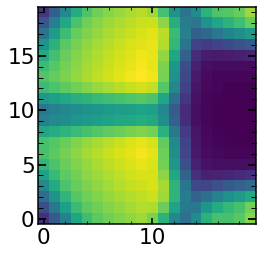

In [49]:
plt.imshow(optPsf_cut_fiber_convolved_downsampled)

In [32]:
1158/40

28.95